In [1]:
%pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   --

In [2]:
#Importing important libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Hyperparameters 
num_classes = 2
batchsize = 16
input_shape = (224, 224, 3)

In [4]:
learning_rate = 0.001
num_epochs= 10

In [5]:
data_dir = r"C:\Pranav P R\College_Academics\internship_siemens\proj\flowsheet\data"

In [6]:
#preparation of data : Loading and splitting
#keras has the ultility to load the images from the given directory
try:
    full_data= tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels = 'inferred',
        label_mode = 'int',
        image_size = (input_shape[0],input_shape[1]),
        batch_size = batchsize,
        shuffle = True,
        seed = 42
    )
    
except FileNotFoundError:
    print(f'error : data directory not found : {data_dir}')
    print("Please update the data_dir")
    exit()

Found 1489 files belonging to 2 classes.


In [7]:
class_names = full_data.class_names
print(f"Classes found: {class_names}")

Classes found: ['flowsheet', 'notflow']


In [8]:
dataset_size = tf.data.experimental.cardinality(full_data).numpy()
print(dataset_size)

94


In [9]:
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size
print(test_size)

15


In [10]:
train_ds = full_data.take(train_size)
val_ds = full_data.skip(train_size).take(val_size)
test_ds = full_data.skip(train_size).skip(val_size)

print(f"Dataset Batches: {dataset_size}")
print(f"Splitting into Train: {train_size}, Validation: {val_size}, Test: {test_size} batches")

Dataset Batches: 94
Splitting into Train: 65, Validation: 14, Test: 15 batches


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# We use a Lambda layer to apply this function.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [13]:
#weights ='imagenet' tells that we will load pre-trained model that is trained for imagenet dataset
#include = False, Excludes final classifier layer
model_base = VGG16(
    weights = 'imagenet',
    include_top = False, 
    input_shape = input_shape
)

In [14]:
#we will be freezing the weights in previous layers and prevents from being updated
model_base.trainable = False

In [15]:
#bringing all inputs through sequential api to build model
inputs = keras.Input(shape=input_shape)   #applying VGG16-specific preprocessing
x = preprocess_input(inputs)   #
x = model_base(x, training=False) #Run through the frozen base model, `training=False` is important 

x = layers.GlobalAveragePooling2D()(x) # Pool features to a single vector
x = layers.Dropout(0.5)(x)  #dd dropout for regularizatio
outputs = layers.Dense(num_classes)(x) # Add our custom output layer (no activation)

In [16]:
model = keras.Model(inputs, outputs)

In [17]:
print('\n Model Summary \n')
model.summary()


 Model Summary 



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)
# Note on loss:
# `SparseCategoricalCrossentropy` is used because our labels are integers (0, 1, ...).
# `from_logits=True` is more numerically stable and is used because our final
# Dense layer has no activation function.

Train the model

In [19]:
print('\n -- Starting model Training -- \n')
history = model.fit(
    train_ds, 
    epochs = num_epochs,
    validation_data = val_ds
)



 -- Starting model Training -- 

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6428 - loss: 2.1284 - val_accuracy: 0.9107 - val_loss: 0.3121
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8737 - loss: 0.4980 - val_accuracy: 0.9420 - val_loss: 0.2222
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9340 - loss: 0.3488 - val_accuracy: 0.9464 - val_loss: 0.1689
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9538 - loss: 0.1744 - val_accuracy: 0.9643 - val_loss: 0.1364
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9486 - loss: 0.2005 - val_accuracy: 0.9688 - val_loss: 0.1246
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9625 - loss: 0.1036 - val_accuracy: 0.9688 - val_loss: 0.1056
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9604 - loss: 0.1274 - val_accuracy: 0.9688 - val_loss: 0.1037
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9635 - loss: 0.1159 

In [20]:
print("\n--- Evaluating on Test Set ---")
loss, accuracy = model.evaluate(test_ds)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


--- Evaluating on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 817ms/step - accuracy: 0.9869 - loss: 0.0433
Test Loss: 0.0480
Test Accuracy: 0.9822



--- Plotting Training History ---


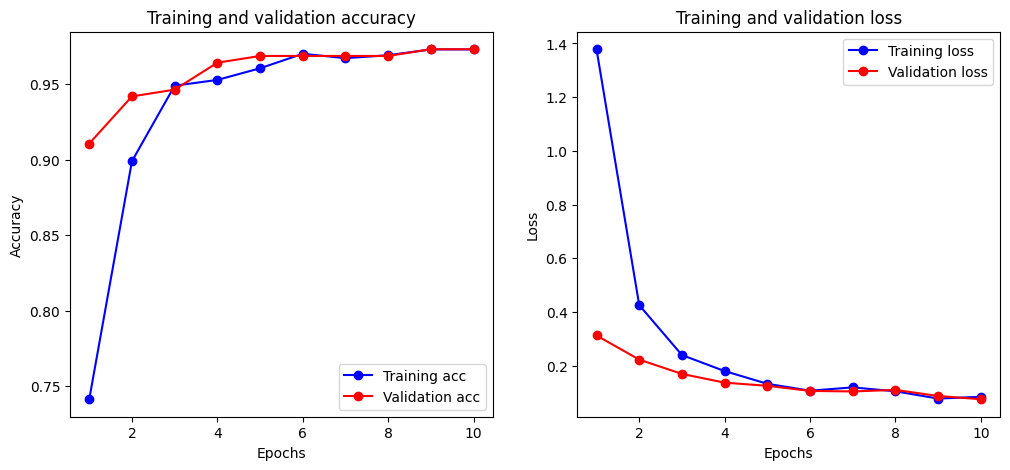

In [21]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

print("\n--- Plotting Training History ---")
plot_history(history)

In [22]:
print("\n--- Saving the trained model ---")
# Use the .keras format which is the new standard, self-contained format.
model_save_path = "vgg16_image_classifier.keras"
model.save(model_save_path)
print(f"Model saved successfully to {model_save_path}")


--- Saving the trained model ---
Model saved successfully to vgg16_image_classifier.keras


In [8]:
# import os
# import cv2
# import albumentations as A
# from tqdm import tqdm

# # Paths
# input_folder = r"C:\Pranav P R\College_Academics\internship_siemens\proj\flowsheet\data\notflow"
# output_folder = r"C:\Pranav P R\College_Academics\internship_siemens\proj\flowsheet\data\notflow\augmented_images"
# os.makedirs(output_folder, exist_ok=True)

# # Number of augmentations per image
# AUGMENTATIONS_PER_IMAGE = 3  # You can increase/decrease this

# # Define augmentation pipeline
# transform = A.Compose([
#     A.PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
#     A.RandomCrop(height=224, width=224, p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.GaussianBlur(p=0.2),
#     A.Resize(256, 256),  # Resize after crop/pad
# ])

# # Process each image
# for filename in tqdm(os.listdir(input_folder)):
#     if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
#         image_path = os.path.join(input_folder, filename)
#         image = cv2.imread(image_path)

#         for i in range(AUGMENTATIONS_PER_IMAGE):
#             augmented = transform(image=image)
#             aug_image = augmented["image"]
#             out_filename = f"{os.path.splitext(filename)[0]}_aug{i+1}.jpg"
#             out_path = os.path.join(output_folder, out_filename)
#             cv2.imwrite(out_path, aug_image)
